In [52]:
import numpy as np
from partition_decode.models import ReluNetClassifier, ReluNetRegressor
from partition_decode.dataset import generate_gaussian_parity, recursive_gaussian_parity, generate_spirals, load_mnist
import torch
from sklearn.ensemble import RandomForestClassifier
from partition_decode.df_utils import (
    get_tree_evals,
    get_forest_evals,
    get_forest_irm,
    get_tree_irm,
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy

## tree measures

In [38]:
X_train, y_train = generate_gaussian_parity(
    n_samples=2000, angle_params=0, random_state=1, cov_scale=0.3
)
X_test, y_test = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=1234, cov_scale=0.3
)

In [20]:
X_train, y_train = load_mnist(
    random_state = 1,
    train=True,
    n_samples=1000,
    save_path="/mnt/ssd3/ronan/pytorch"
)

X_test, y_test = load_mnist(
    random_state = 1234,
    train=False,
    n_samples=10000,
    save_path="/mnt/ssd3/ronan/pytorch"
)

In [36]:
n_estimators = [1, 1, 1, 1, 1, 1, 2, 5, 10, 20]
max_depths = [4, 8, 16, 32, 64, None, None, None, None, None]
gen_errors = []
irms = []
train_errors = []
test_errors = []
for n_trees, max_depth in zip(n_estimators, max_depths):
    model = RandomForestClassifier(bootstrap=False, n_estimators=n_trees, max_depth=max_depth, n_jobs=-2)
    model = model.fit(X_train, y_train)
    train_errors.append(1 - np.mean(y_train == model.predict(X_train)))
    test_errors.append(1 - np.mean(y_test == model.predict(X_test)))
    gen_errors.append(test_errors[-1] - train_errors[-1])
    irms.append(get_forest_irm(model, X_train))

In [37]:
X = [1, 1]
a = 1
a += entropy(X) if np.sum(X) > 0 else 0
print(a)

1.6931471805599454


In [38]:
def mean_sim_entropy(X):
    score = 0
    for row in X:
        score += entropy(X @ row)
    score /= X.shape[0]
    return score

Ms = [irm @ irm.T / irm.sum(axis=1)[0] for irm in irms]
l1_scores = [np.mean(M) for M in Ms]
l2_scores = [np.mean(M**2) for M in Ms]
mean_entropy_scores = [np.mean(entropy(M, axis=1)) for M in Ms]
mean_entropy_v2_scores = [mean_sim_entropy(irm) for irm in irms]

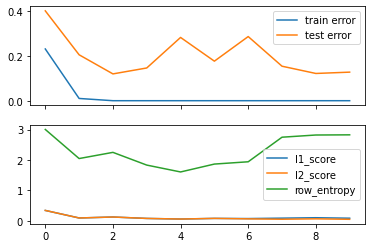

In [39]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(np.arange(len(gen_errors)), train_errors, label='train error')
axes[0].plot(np.arange(len(gen_errors)), test_errors, label='test error')
axes[0].legend()

axes[1].plot(np.arange(len(gen_errors)), l1_scores, label='l1_score')
axes[1].plot(np.arange(len(gen_errors)), l2_scores, label='l2_score')
axes[1].plot(np.arange(len(gen_errors)), mean_entropy_v2_scores, label='row_entropy')
axes[1].legend()
plt.show()

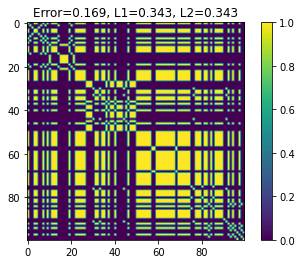

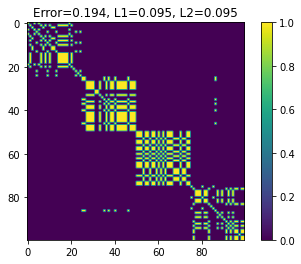

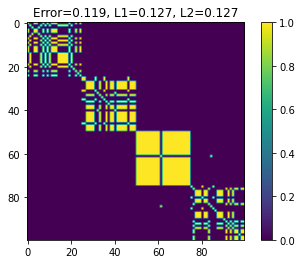

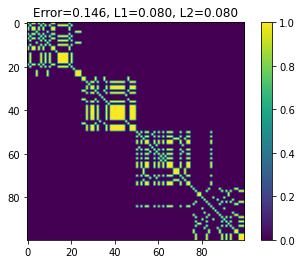

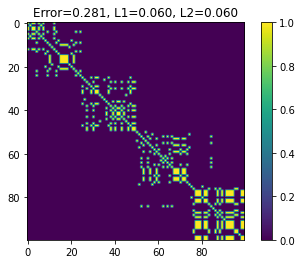

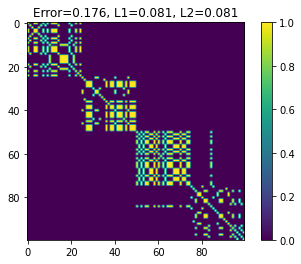

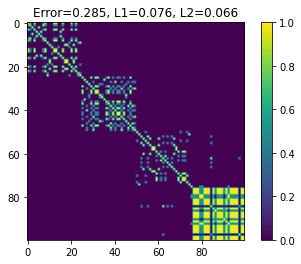

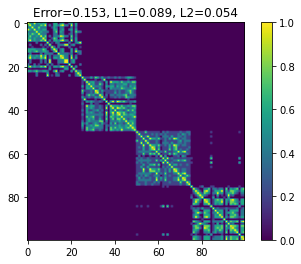

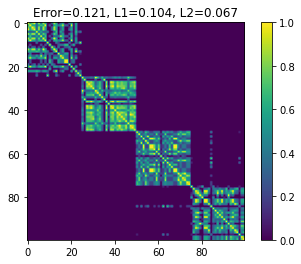

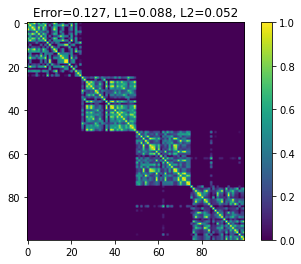

In [40]:
for irm, gen_error in zip(irms, gen_errors):
    M = irm @ irm.T / irm.sum(axis=1)[0]
    plt.imshow(M)
    plt.title(f'Error={gen_error:.3f}, L1={np.mean(M):.3f}, L2={np.mean(M**2):.3f}')
    plt.colorbar()
    plt.show()

## Relu net

In [98]:
X, y = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=None, cov_scale=1.0
)

# X, y = recursive_gaussian_parity(
#     n_samples=1024, recurse_level=2, random_state=None, cov_scale=0.3
# )

# X, y = generate_spirals(
#     n_samples=1024, random_state=None, noise=0.7
# )

new_y = np.zeros((y.shape[0], len(np.unique(y))))
new_y[np.arange(y.shape[0]), y] = 1
y = new_y

In [100]:
model = ReluNetRegressor(
    verbose=1, n_epochs=100, hidden_layer_dims=[10],
    learning_rate=0.01, early_stop_thresh=0, bias=True)#, loss=torch.nn.BCEWithLogitsLoss)
model = model.fit(X, y)

Results for epoch 1, MSELoss=0.28, mse=0.28
Results for epoch 6, MSELoss=0.15, mse=0.15
Results for epoch 11, MSELoss=0.15, mse=0.15
Results for epoch 16, MSELoss=0.19, mse=0.19
Results for epoch 21, MSELoss=0.25, mse=0.25
Results for epoch 26, MSELoss=0.16, mse=0.16
Results for epoch 31, MSELoss=0.15, mse=0.15
Results for epoch 36, MSELoss=0.20, mse=0.20
Results for epoch 41, MSELoss=0.14, mse=0.14
Results for epoch 46, MSELoss=0.19, mse=0.19
Results for epoch 51, MSELoss=0.17, mse=0.17
Results for epoch 56, MSELoss=0.14, mse=0.14
Results for epoch 61, MSELoss=0.18, mse=0.18
Results for epoch 66, MSELoss=0.15, mse=0.15
Results for epoch 71, MSELoss=0.15, mse=0.15
Results for epoch 76, MSELoss=0.15, mse=0.15
Results for epoch 81, MSELoss=0.17, mse=0.17
Results for epoch 86, MSELoss=0.20, mse=0.20
Results for epoch 91, MSELoss=0.17, mse=0.17
Results for epoch 96, MSELoss=0.21, mse=0.21


## Get region affine function

[d] * [d, d2] * relu * [d2, k] -> [k]

[d] * [d, d2] * [d2, d2] * [d2, k] -> [n, k]

[n, d] * [d, d2]


$y = W (relu (Wx + b)) + b = [W, b] [relu(Wx + b), 1] = [W, b] [R(Wx + b), 1] = [W, b] [RWx + Rb, 1] = WRWx + (WRb + b)$

In [101]:
# Single sample
x = X[1]# .reshape(1, -1)
W = np.eye(x.shape[-1]) # account for bias
b = np.zeros(x.shape[-1])
with torch.no_grad():
    x_pred = torch.autograd.Variable(torch.from_numpy(x).float())
    for module in model.model_:
        x_pred = module(x_pred)
        
        if type(module) == torch.nn.modules.activation.ReLU:
            act_relus = (x_pred.numpy() > 0).astype(int)
            layer_w = np.diag(act_relus)
            layer_b = 0
        else:
            layer_w = module.weight.numpy().T
            if module.bias is not None: # in case bias=False
                layer_b = module.bias.numpy()
            else:
                layer_b = 0
            
        W =  W @ layer_w
        b =  b @ layer_w + layer_b

np.testing.assert_array_almost_equal(x_pred, x @ W + b)

In [108]:
# 1 hidden layer, returns weight matrix dimension h x d
print(f'h={model.hidden_layer_dims}')
print(f'Target output k x h x d+1 = {len(np.unique(y))} x {model.hidden_layer_dims[0]} x {X.shape[-1]+1}')
print('--------------------------------------')
with torch.no_grad():
    l1 = model.model_[0]
    l2 = model.model_[2]
    W = []
    b = []
    b_ult = []
    for W_out, b_out in zip(l2.weight.numpy(), l2.bias.numpy()):
        W.append(np.diag(W_out) @ l1.weight.numpy())
        b.append(np.diag(W_out) @ l1.bias.numpy())
        b_ult.append(b_out)
        
    W = np.asarray(W)
    b = np.asarray(b)
    b_ult = np.asarray(b_ult)
    
print(W.shape, b.shape, b_ult.shape)

h=[10]
Target output k x h x d+1 = 2 x 10 x 3
--------------------------------------
(2, 10, 2) (2, 10) (2,)


In [109]:
irm = model.get_internal_representation(X)

In [110]:
np.testing.assert_array_almost_equal(
    model.predict(X),
    np.vstack([
        np.diag(irm @ (bi.reshape(-1, 1) + Wi @ X.T)) + bend
        for Wi, bi, bend in zip(W, b, b_ult)]).T
)

In [13]:
# Multiple samples
n = X.shape[0]
W = np.asarray([np.eye(X.shape[-1])]*n) # account for bias
b = np.zeros(X.shape[-1])
with torch.no_grad():
    x_pred = torch.autograd.Variable(torch.from_numpy(X).float())
    for module in next(model.model_.modules(:
        x_pred = module(x_pred)
        
        if type(module) == torch.nn.modules.activation.ReLU:
            act_relus = (x_pred.numpy() > 0).astype(int)
            layer_w = np.asarray(np.diag(R) for R in act_relus)
            layer_b = 0
        else:
            layer_w = module.weight.numpy().T
            layer_b = module.bias.numpy()
            
        W =  W @ layer_w
        b =  b @ layer_w + layer_b

np.testing.assert_array_almost_equal(x_pred, x @ W + b)

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [78]:
irm = []
for x in X:
    W = np.eye(x.shape[-1]) # account for bias
    b = np.zeros(x.shape[-1])
    sample_rep = []
    with torch.no_grad():
        x_pred = torch.autograd.Variable(torch.from_numpy(x).float())
        for module in next(model.model_.modules()):
            x_pred = module(x_pred)

            if type(module) == torch.nn.modules.activation.ReLU:
                act_relus = (x_pred.numpy() > 0).astype(int)
                layer_w = np.diag(act_relus)
                layer_b = 0
            else:
                layer_w = module.weight.numpy().T
                layer_b = module.bias.numpy()

            W =  W @ layer_w
            b =  b @ layer_w + layer_b

            np.testing.assert_array_almost_equal(x_pred, x @ W + b)

            if type(module) == torch.nn.modules.activation.ReLU:
                sample_rep.append(np.linalg.norm(W, ord=2, axis=0))
    irm.append(np.hstack(sample_rep))
irm = np.vstack(irm)

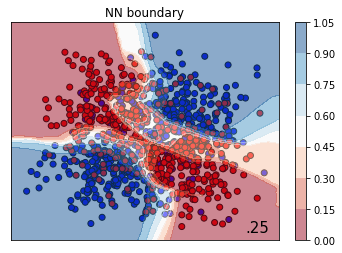

In [144]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, 1, 1)

# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k")
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

score = net.score(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = net.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('NN boundary')
ax.text(
    xx.max() - 0.3,
    yy.min() + 0.3,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right",
)
plt.colorbar()
plt.show()

In [145]:
irm = net.get_internal_representation(X, penultimate=False)

## Parameter impute

In [142]:
X_train, y_train = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=None, cov_scale=1.0
)

# X, y = recursive_gaussian_parity(
#     n_samples=1024, recurse_level=2, random_state=None, cov_scale=0.3
# )

# X, y = generate_spirals(
#     n_samples=1024, random_state=None, noise=0.7
# )

In [143]:
model = ReluNetClassifier(
    verbose=1, n_epochs=10, hidden_layer_dims=[10],
    learning_rate=0.01, early_stop_thresh=0)#, loss=torch.nn.BCEWithLogitsLoss)

In [144]:
model = model.fit(X_train, y_train)
with torch.no_grad():
    print(np.mean(y_train == model.predict(X_train)))

# model.n_epochs = 0
# model._train_model(X_train, y_train)
# print(np.mean(y_train == model.predict(X_train)))

Results for epoch 1, CrossEntropyLoss=0.73, 01_error=0.50
Results for epoch 6, CrossEntropyLoss=0.49, 01_error=0.23
0.7373046875


In [145]:
new_model = ReluNetClassifier(verbose=1, n_epochs=0, hidden_layer_dims=[20],
    learning_rate=0.01, early_stop_thresh=0
)
new_model._build_model(X_train.shape[-1], len(np.unique(y_train)))
with torch.no_grad():
    for prior_layer, new_layer in zip(model.model_, new_model.model_,):
        if isinstance(new_layer, torch.nn.ReLU):
            continue
        width, depth = prior_layer.weight.shape
        new_layer.weight[:width, :depth] = prior_layer.weight
        new_layer.bias[:width] = prior_layer.bias

new_model._train_model(X_train, y_train)

In [146]:
print(np.mean(y_train == new_model.predict(X_train)))

0.73046875


In [147]:
new_model.model_[0].weight

Parameter containing:
tensor([[-0.6229,  0.6128],
        [-0.2899,  0.2469],
        [ 0.6234, -0.0520],
        [-0.6382,  0.6064],
        [ 0.6041,  0.8540],
        [-0.2757,  0.3778],
        [ 0.0388,  0.1128],
        [-0.9102, -0.5263],
        [-0.6184,  0.3038],
        [-0.1628, -0.6668],
        [ 0.0841, -0.1184],
        [ 0.2108, -0.3145],
        [ 0.0176,  0.5059],
        [ 0.2708,  0.3724],
        [ 0.3626, -0.2471],
        [-0.0148,  0.2273],
        [ 0.3343, -0.2632],
        [-0.0415,  0.4311],
        [ 0.4919, -0.2792],
        [-0.0914,  0.4419]], requires_grad=True)

In [148]:
model.model_[0].weight

Parameter containing:
tensor([[-0.6229,  0.6128],
        [-0.2899,  0.2469],
        [ 0.6234, -0.0520],
        [-0.6382,  0.6064],
        [ 0.6041,  0.8540],
        [-0.2757,  0.3778],
        [ 0.0388,  0.1128],
        [-0.9102, -0.5263],
        [-0.6184,  0.3038],
        [-0.1628, -0.6668]], requires_grad=True)

In [129]:
model.model_

Sequential(
  (linear0): Linear(in_features=2, out_features=10, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=10, out_features=2, bias=True)
)

## Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from partition_decode.metrics import mse_classification

In [52]:
n_train = 1000
X_train, y_train = load_mnist(
    n_samples=n_train, save_path="/mnt/ssd3/ronan/pytorch", train=True, onehot=False
)

In [53]:
y_train.shape

(1000,)

In [54]:
model = RandomForestClassifier(n_estimators=2, max_depth=None, bootstrap=False)
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)

In [55]:
np.unique(y_train_pred)

array([0., 1.])

In [56]:
mse_classification(y_train, y_train_pred)

0.0

In [57]:
y_train_pred[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
z = np.asarray([[0, 1], [1, 0]])

In [37]:
z[np.arange(z.shape[0]), np.asarray([0, 1])] -= 1

In [41]:
np.linalg.norm(z, axis=1)

array([1.41421356, 1.41421356])

In [40]:
np.linalg.norm(z[0])

1.4142135623730951

## RRF

In [48]:
from partition_decode.models import RandomReluTransform
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [53]:
X = np.random.normal(0, 1, (200, 5))
y = [0, 1] * (X.shape[0] // 2)
new_y = np.zeros((len(y), 2))
new_y[np.arange(new_y.shape[0]), y] = 1
y = new_y

In [54]:
rrf = RandomReluTransform(500)
rrf.fit(X)
lr = MLPRegressor(hidden_layer_sizes=(), alpha = 0, max_iter=1000)
lr = lr.fit(rrf.transform(X), y)

In [47]:
np.mean(lr.predict(rrf.transform(X)).argmax(1) == y.argmax(1))

1.0

In [38]:
weights = np.random.normal(0, 1, (5, 200))
weights /= np.linalg.norm(weights, axis=0)

In [39]:
np.linalg.norm(weights[:, 0])

1.0

In [40]:
Z = X @ weights

In [42]:
rrf = RandomReluTransform(200)
rrf.fit(X)
lr = LinearRegression()
lr = lr.fit(Z, y)

In [43]:
np.mean(lr.predict(Z).argmax(1) == y.argmax(1))

0.52

In [2]:
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [12]:
n = 100
fill_fracs = [0.1, 0.1, 0.1, 0.2, 0.3, 0.4]# np.linspace(0, 1, 11)[1:-1]
ms = [10, 20, 50, 100, 200, 500]
df_mat = []
for m, frac in zip(ms, fill_fracs):
    for rep in range(40):
        X = np.random.choice([0, 1], p=[1-frac, frac], size=(n, m))
        evals = np.linalg.svd(X, compute_uv=False)**2 / m
        ent = entropy(evals)
        sim_sum = np.mean(X @ X.T / m)
        ent_padded = entropy(np.concatenate((evals, [0]*(n-len(evals)))))
        df_mat.append(
            [n, m, frac, np.sum(evals), np.linalg.norm(evals)**2 / n, sim_sum, ent, ent_padded]
        )

In [13]:
# df = pd.DataFrame(df_mat, columns=['n_rows', 'n_cols', 'fill_frac', 'L1', 'L2', 'L2_normalized'])
df = pd.DataFrame(df_mat, columns=['n_rows', 'n_cols', 'fill_frac', 'L1', 'L2', 'Gram_mean', 'Entropy', 'Entropy_padded'])

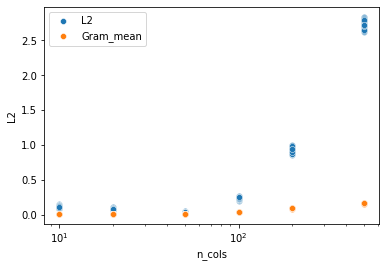

In [14]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=df, x='n_cols', y='L2', ax=ax, label='L2')
sns.scatterplot(data=df, x='n_cols', y='Gram_mean', ax=ax, label='Gram_mean')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.show()

In [17]:
X = np.random.normal(0, 1, (10, 5))
X = X @ X.T / X.shape[1]
evals = np.linalg.svd(X, compute_uv=False, hermitian=True)
print(np.mean(X**2))
print(np.linalg.norm(evals)**2)

0.2186881192372857
21.86881192372857


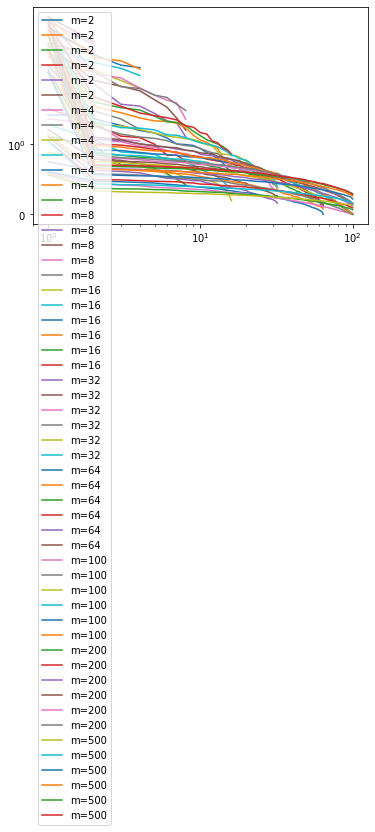

In [22]:
n = 100
fill_fracs = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]# np.linspace(0, 1, 11)[1:-1]
ms = [2, 4, 8, 16, 32, 64, 100, 200, 500]
df_mat = []
fig, ax = plt.subplots(1, 1)
for m in ms:
    for frac in fill_fracs:
        X = np.random.choice([0, 1], p=[1-frac, frac], size=(n, m))
        evals = np.linalg.svd(X, compute_uv=False) / np.sqrt(m) #**2 / m
        ax.plot(np.arange(len(evals))+1, evals, label=f'm={m}')
        ent = entropy(evals)
        max_ent = entropy([1]*int(min(n, m)))
        ent_padded = entropy(np.concatenate((evals, [0]*(n-len(evals)))))
        df_mat.append(
            [n, m, frac, np.sum(evals), np.linalg.norm(evals), ent, ent/max_ent, max_ent, ent_padded]
        )

plt.legend()
ax.set_yscale('symlog')
ax.set_xscale('log')
plt.show()

In [23]:
df = pd.DataFrame(
    df_mat,
    columns=[
        'n_rows', 'n_cols', 'fill_frac', 'L1', 'L2', 'Entropy',
        'Entropy_normalized', 'Entropy_max', 'Entropy_padded'])

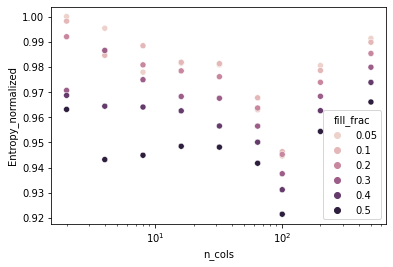

In [24]:
sns.scatterplot(data=df, x='n_cols', y='Entropy_normalized', hue='fill_frac')
plt.xscale('log')
# plt.yscale('log')

## max min entropy

In [36]:
X = np.asarray([
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
])
print(X @ X.T)
print(entropy(np.linalg.svd(X, compute_uv=False)**2))
print(-np.log(X.sum() / (np.prod(X.shape))))

0.8446698683009523
0.3746934494414107


In [43]:
X = np.asarray([
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 1],
    [0, 0, 1],
])
print(entropy(np.linalg.svd(X, compute_uv=False)**2))
print(-np.log(X.sum() / (np.prod(X.shape))))

0.9141778554279377
0.6931471805599453


In [46]:
X = np.asarray([
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 0, 1, 1],
])
print(np.linalg.svd(X, compute_uv=False)**2)
print(entropy(np.linalg.svd(X, compute_uv=False)**2))

X = np.asarray([
    [1, 0, 0, 1],
    [1, 1, 0, 0],
    [0, 1, 1, 0],
    [0, 0, 1, 1],
])
print(np.linalg.svd(X, compute_uv=False)**2)
print(entropy(np.linalg.svd(X, compute_uv=False)**2))

[5.22274331 2.11238872 0.47339772 0.19147026]
0.8866317491315305
[4.000000e+00 2.000000e+00 2.000000e+00 4.672828e-33]
1.0397207708399179


In [55]:
X = np.asarray([
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [0, 1, 1, 0],
    [0, 0, 1, 1],
])
print(np.linalg.svd(X, compute_uv=False)**2)
print(entropy(np.linalg.svd(X, compute_uv=False)**2))

X = np.asarray([
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [1, 0, 1, 0],
    [1, 0, 0, 0],
])
print(np.linalg.svd(X, compute_uv=False)**2)
print(entropy(np.linalg.svd(X, compute_uv=False)**2))

X = np.asarray([
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1],
    [0, 1, 1],
])
print(np.linalg.svd(X, compute_uv=False)**2)
print(entropy(np.linalg.svd(X, compute_uv=False)**2))

X = np.asarray([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
])
print(np.linalg.svd(X, compute_uv=False)**2)
print(entropy(np.linalg.svd(X, compute_uv=False)**2))

[3.53208889 2.34729636 1.         0.12061476]
1.059502884841204
[4.56155281 1.         0.43844719 0.        ]
0.6981938567096306
[7. 1. 1.]
0.6837389058487534
[1.20000000e+01 6.16297582e-33 1.51232127e-66]
3.936685802479677e-32


## knn

In [34]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
# knn = KNeighborsRegressor(n_neighbors=10, weights='distance', p=2)
knn = KNeighborsClassifier(n_neighbors=100, weights='distance', p=2)

X_train, y_train = generate_gaussian_parity(
    n_samples=100, angle_params=0, random_state=1, cov_scale=0.3
)
y = np.zeros((100, 2))
y[np.arange(y.shape[0]), y_train] = 1
X_test, y_test = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=1234, cov_scale=0.3
)

knn = knn.fit(X_train, y_train)

In [35]:
knn.predict_proba(X_train)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.